# Final Project Writeup - Brain Tumor Imaging Detection CNN - Ishaan Pahuja

### Motivation
Convolutional Neural Networks are at the hear of many computer vision advances

Import libraries and packages to implement deep learning network and visualizations.

In [ ]:
# For data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Other libraries for system and random procedures
import os
import random

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# Primary DeepLearning Libraries
# tensorflow is built on top and packaged with the keras api
import tensorflow as tf


# DL model with iterative layer scheme
from tensorflow.keras.models import Sequential
# Different types of layers within our sequential neural net
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import  Dropout, BatchNormalization, GlobalAveragePooling2D
# IO handling import to create categorized DataSet from folder heirarchy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Adaptive movement estimation optimizer that is a modified version of
# stochastic gradient descent
from tensorflow.keras.optimizers import Adam
# Ridge regularization to prevent overfitting
from tensorflow.keras.regularizers import l2
# PreTrained Model to speed up training process by obtaining
# pre-existing convolution filters from a massive varied dataset
# and quickly narrowing the necessary filters down
from tensorflow.keras.applications import Xception

# Data augmentation class to modify image type data
from tensorflow.keras.preprocessing import image
#Early Stopping to prevent training from overfitting when metrics halt improvement
from tensorflow.keras.callbacks import EarlyStopping


## Exploring the Data Set

After loading the dataset into our enivronment we initially explored the class ratios as this is an important factor take into consideration when creating class identification models as we are. Using the label counts we created a pi chart to represent our class balances below.

Class distribution in the dataset:
label
yes    155
no      98
Name: count, dtype: int64

Percentage distribution:
label
yes    61.26
no     38.74
Name: count, dtype: float64


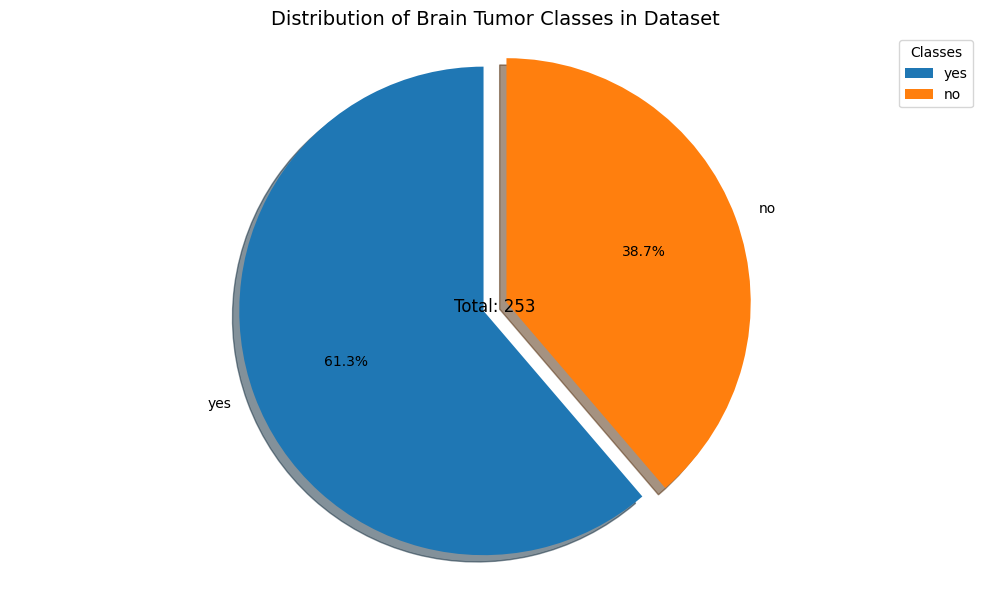

In [ ]:
# Get dataset Folder and initialize empty vectors
data_dir = '/content/brain_tumor_dataset'
filepaths = []
labels = []

# Iterate through each folder
folds = os.listdir(data_dir)
for fold in folds:
    folderpath = os.path.join(data_dir, fold)
    filelist = os.listdir(folderpath)
    # Iterate through each image file in the folder
    for file in filelist:
        # Collect files and
        filepath = os.path.join(folderpath, file)
        filepaths.append(filepath)
        labels.append(fold)

# Compile File paths and their label into a dataframe
file_series = pd.Series(filepaths, name= 'filepath')
label_series = pd.Series(labels, name='label')
df = pd.concat([file_series, label_series], axis= 1)

# Calculate class distribution
label_counts = df['label'].value_counts()
print("Class distribution in the dataset:")
print(label_counts)
print("\nPercentage distribution:")
percentage_distribution = (label_counts / len(df) * 100).round(2)
print(percentage_distribution)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
        startangle=90, shadow=True, explode=[0.05] * len(label_counts))
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Distribution of Brain Tumor Classes in Dataset', fontsize=14)
plt.legend(title="Classes", loc="best")

# Add total count in the center
total_count = len(df)
plt.annotate(f'Total: {total_count}', xy=(0, 0), xytext=(0, 0),
             textcoords='offset points', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


As we see the yes class outweighs the no class by nearly 50%. This factor is necessary to be accounted for as the large class imbalance will reward the model we are developing to select yes just due to the quantity of yes'.

So we will create our Training, Test, and Validation sets below. In order to account for the class imbalance we will oversample from the No class population within our training dataset to balance the classes for training.


In [ ]:
train_df , extra_df = train_test_split(df ,train_size = 0.7 ,
                                       shuffle = True ,random_state = 999)
from sklearn.utils import resample

# Identify the majority and minority classes
class_counts = train_df['label'].value_counts()
majority_class = class_counts.index[0]
minority_class = class_counts.index[1]

# Separate majority and minority classes
majority_df = train_df[train_df['label'] == majority_class]
minority_df = train_df[train_df['label'] == minority_class]

print(f"Majority class '{majority_class}': {len(majority_df)} samples")
print(f"Minority class '{minority_class}': {len(minority_df)} samples")

# Upsample minority class
minority_df_upsampled = resample(minority_df,
                                replace=True,  # Sample with replacement
                                n_samples=len(majority_df), # Match majority class size
                                random_state=999)  # For reproducibility

# Combine majority class with upsampled minority class
train_df_balanced = pd.concat([majority_df, minority_df_upsampled])
# Shuffle the balanced dataset
train_df = train_df_balanced.sample(frac=1, random_state=999).reset_index(drop=True)

# Split the extra data into test and validation sets to evaluate performance
# without memorization bias
val_df , test_df = train_test_split(extra_df ,train_size = 0.5 ,
                                    shuffle = True ,random_state = 999)

After exploring the class ratios we decided to explore our data set through observing random samples of both classes to gain a personal understanding of the images in both. Here we generate image data sets using keras tools to load from the file paths and labels of the data frame.

In [ ]:
# Create instance of a class object with functionalities to produce/load
# image based datasets
image_set_generator = ImageDataGenerator(rescale=1./255)

# Create training data set with predefined params to:
# Resize images for uniformity - Default 256x256 pixels
# Define color type
# Define Classification type:Binary Onehot encoding of classes(0:NoTumor,1:Tumor)
train_ds = image_set_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(256, 256),
    )
# Repeat for test and validation sets
test_ds = image_set_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(256, 256),
    )

val_ds = image_set_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(256, 256),
    )



Found 177 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.


# Understanding the Data
Now that we have our ImageData loaded in a usable state we can directly observe the data to get a personal  understanding of the differences between the two categories where patients have a tumor or don't.

Observe a visual of the differences between tumor and non-tumor images below

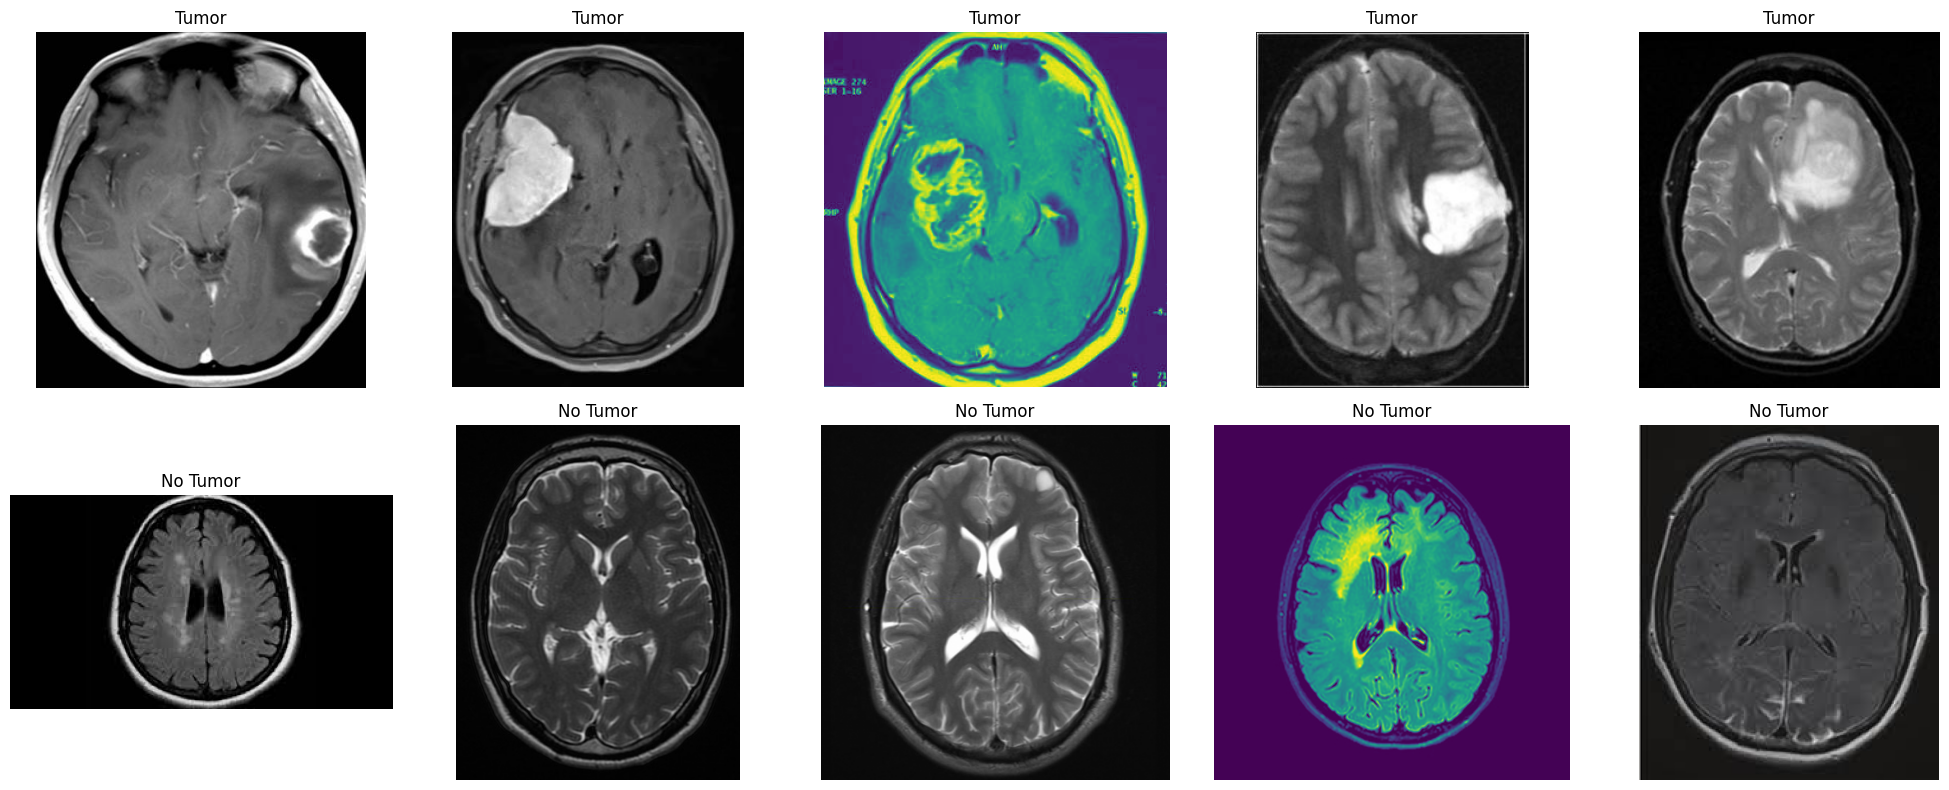

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec


# Get 5 random Non-tumor images
sampled_tumorless = train_df[train_df['label'] == 'no'].sample(5, random_state=123)
#Create a list of the filepath values of this sample
sampled_tumorless = list(sampled_tumorless['filepath'])

# Get 5 random tumor images
sampled_tumor = train_df[train_df['label'] == 'yes'].sample(5, random_state=123)
#Create a list of the filepath values of this sample
sampled_tumor = list(sampled_tumor['filepath'])


plt.figure(figsize=(20, 8))
for i in range(5):
    # First row (using list1)
    plt.subplot(2, 5, i+1)
    img = mpimg.imread(sampled_tumor[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title("Tumor")

    # Second row (using list2)
    plt.subplot(2, 5, i+6)
    img = mpimg.imread(sampled_tumorless[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title("No Tumor")

plt.tight_layout()

# Show the plot
plt.show()


As we can observe majority of the tumor class images have spherical masses. This is the primary feature we will likely be training our convolution filters to collect.

# Creating the MODELS

We will be comparing two models, one built and pre-learned from a generalized image classifier, and the other built and initialized from the ground up on this data. This is being done to compare the results of generalized architecture with specialized architecture.

Our pretrained architecture will load convolution and pooling layers from the Xception model with the filters trained on the imagenet dataset. Imagenet is a large visual database with over 14 million human labeled images. Pretraining a model on this data set will likely accelerate the fitting of its necessary convolutional layers. However certain necessary layers may already be harshly punished leading to inaccuracies within the model.

Our self constructed convolutional neural network wil have a series of 4 convolutional/pooling layers that are randomly initiated and have RELu activations for efficiency. Using batchNormalization and l2 regularization we feed our convolution feature data to a drop layer and dense layer. Finally our data is fed into a softmax, utilizing in categorical settings, activated dense output layer.

Finally we compile these two models utilizing categorical_crossentropy as our loss function due to the output of category data. For optimization we use Adamax to optimize these models in training as the squared gradient descent algorithm in adamax combines infinite bound regularization and momentum to efficently adapt learning rates

In [ ]:

pretrained_layers = Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    )
model1 = Sequential()
model1.add(pretrained_layers)
# Pooling layer to condense output images of convolution filters
model1.add(GlobalAveragePooling2D())
# Batch Normalization to prevent overfitting by normalizing activations to minibatch of neurons
model1.add(BatchNormalization())
# Dropout Layer to reduce overfitting by randomly deselecting neurons
model1.add(Flatten())
model1.add(Dropout(0.5))
# Output Layer fully connected to previous layer
model1.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(2, activation='softmax'))


model2 = Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dense(2, activation='softmax'))


model1.summary()
model2.summary()

model1.compile(
    optimizer='adamax',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.compile(
    optimizer='adamax',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,394,730 (81.61 MB)

 Trainable params: 21,336,106 (81.39 MB)

 Non-trainable params: 58,624 (229.00 KB)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,996,354 (49.58 MB)

 Trainable params: 12,996,226 (49.58 MB)

 Non-trainable params: 128 (512.00 B)

We train our transfer learned model for only 20 epochs to prevent massive overfitting due to the convolutional layers already being partially learned for image classification.

In [ ]:
os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

history1 = model1.fit(
    train_ds,
    epochs=20,
    batch_size=32,
    validation_data=val_ds
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.6255 - loss: 5.3448 - val_accuracy: 0.6579 - val_loss: 4.9851
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 605ms/step - accuracy: 0.8582 - loss: 4.7725 - val_accuracy: 0.7368 - val_loss: 4.7151
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.9662 - loss: 4.3082 - val_accuracy: 0.7895 - val_loss: 4.6043
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step - accuracy: 0.9974 - loss: 4.1199 - val_accuracy: 0.7895 - val_loss: 4.4746
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 641ms/step - accuracy: 1.0000 - loss: 3.9663 - val_accuracy: 0.8158 - val_loss: 4.3373
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.9881 - loss: 3.8821 - val_accuracy: 0.8947 - val_loss: 4.1971
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - accuracy: 0.9974 - loss: 3.7484 - val_accuracy: 0.8947 - val_loss: 4.0742
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - accuracy: 0.9808 - loss: 3.7389 - val_accuracy: 0.9211 - val_loss: 3

In [ ]:
os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

print("\nBenchmarking on Test Data:")
test_loss1, test_accuracy1 = model1.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss1:.4f}")
print(f"Test Accuracy: {test_accuracy1:.4f}")

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

# Predict probabilities on test dataset
test_pred_prob1 = model1.predict(test_ds)

# Convert probabilities to binary predictions (0 or 1)
test_pred1 = np.argmax(test_pred_prob1,axis=1)

# Get true labels for test dataset
test_true1 = test_ds.classes

# Calculate metrics for each dataset
def calculate_metrics(true, pred):
    cm = confusion_matrix(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    return cm, precision, recall, f1

test_cm1, test_precision1, test_recall1, test_f1_1 = calculate_metrics(test_true1, test_pred1)

print("\nTesting Metrics:")
print("Confusion Matrix:\n", test_cm1)
print(f"Precision: {test_precision1:.4f}")
print(f"Recall: {test_recall1:.4f}")
print(f"F1 Score: {test_f1_1:.4f}")


Benchmarking on Test Data:
Test Loss: 3.1400
Test Accuracy: 0.8158
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step

Testing Metrics:
Confusion Matrix:
 [[ 8  7]
 [12 11]]
Precision: 0.6111
Recall: 0.4783
F1 Score: 0.5366


We train our from scratch model for 50 epochs as the model's convolutional layers are not yet learning to any form of image classification data.

In [ ]:
os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

history2 = model2.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    validation_data=val_ds
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step - accuracy: 0.6334 - loss: 12.5986 - val_accuracy: 0.6316 - val_loss: 9.1842
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.7271 - loss: 8.8910 - val_accuracy: 0.8684 - val_loss: 8.1674
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7809 - loss: 7.7349 - val_accuracy: 0.7895 - val_loss: 7.4294
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8574 - loss: 6.9646 - val_accuracy: 0.8947 - val_loss: 6.8961
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9240 - loss: 6.3416 - val_accuracy: 0.9211 - val_loss: 6.4590
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9422 - loss: 5.9102 - val_accuracy: 0.8947 - val_loss: 6.0797
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9173 - loss: 5.5465 - val_accuracy: 0.9211 - val_loss: 5.7492
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9493 - loss: 5.1695 - val_accuracy: 0.8947 - val_loss

In [ ]:
os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

print("\nBenchmarking on Test Data:")
test_loss2, test_accuracy2 = model2.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss2:.4f}")
print(f"Test Accuracy: {test_accuracy2:.4f}")

# prompt: Get the models confusion matrix, precision, recall, and F1 score for the testing datasets

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

os.environ['PYTHONHASHSEED'] = str(123)
tf.random.set_seed(123)
tf.random.set_global_generator(123)
np.random.seed(123)

# Predict probabilities on test dataset
test_pred_prob2 = model2.predict(test_ds)

# Convert probabilities to binary predictions (0 or 1)
test_pred2 = np.argmax(test_pred_prob2,axis=1)

# Get true labels for test dataset
test_true2 = test_ds.classes

# Calculate metrics for each dataset
def calculate_metrics(true, pred):
    cm = confusion_matrix(true,pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    return cm, precision, recall, f1

test_cm2, test_precision2, test_recall2, test_f1_2 = calculate_metrics(test_true2, test_pred2)

print("\nTesting Metrics:")
print("Confusion Matrix:\n", test_cm2)
print(f"Precision: {test_precision2:.4f}")
print(f"Recall: {test_recall2:.4f}")
print(f"F1 Score: {test_f1_2:.4f}")


Benchmarking on Test Data:
Test Loss: 1.6222
Test Accuracy: 0.8684
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 

Testing Metrics:
Confusion Matrix:
 [[ 6  9]
 [ 8 15]]
Precision: 0.6250
Recall: 0.6522
F1 Score: 0.6383


# Results



Now that our models are trained we can evaluate them and compare their training progress
PreTrained:

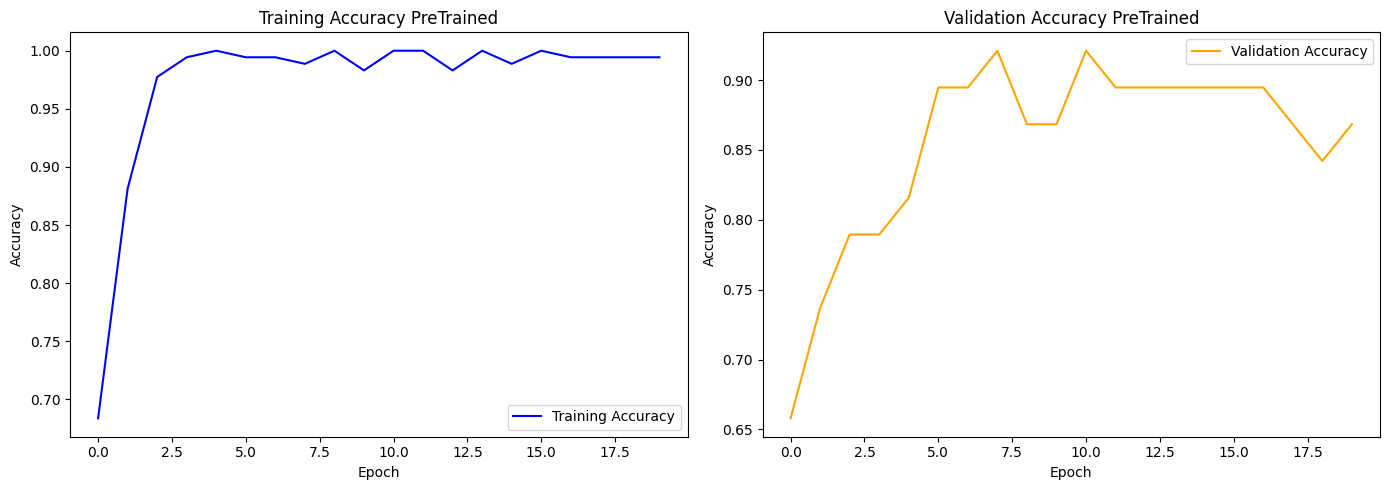

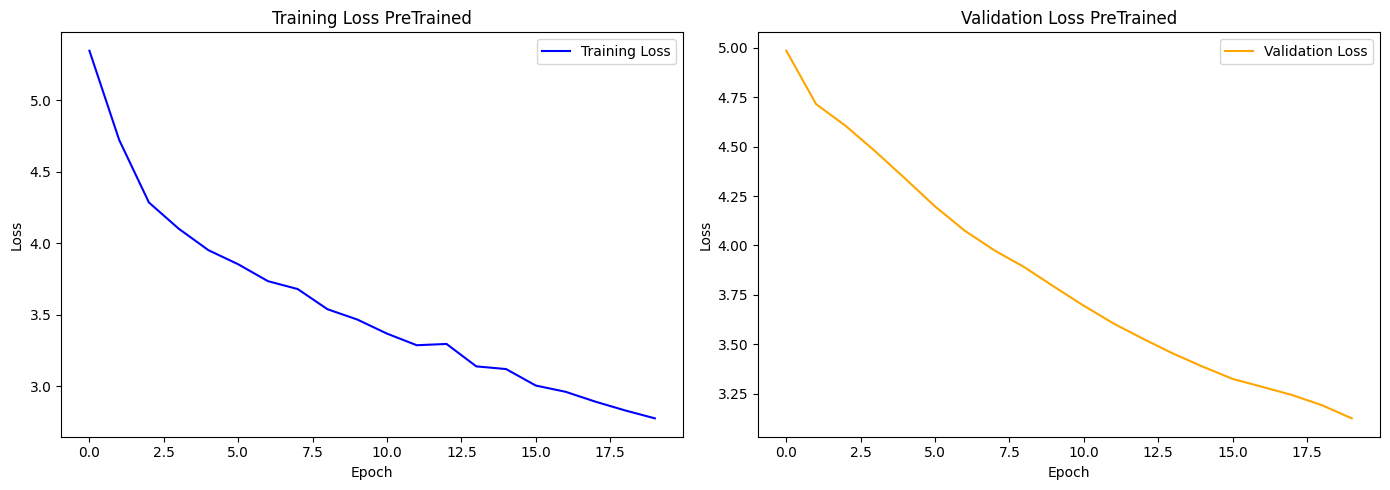

In [ ]:
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy PreTrained')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy PreTrained')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss PreTrained')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss PreTrained')
plt.legend()

plt.tight_layout()
plt.show()

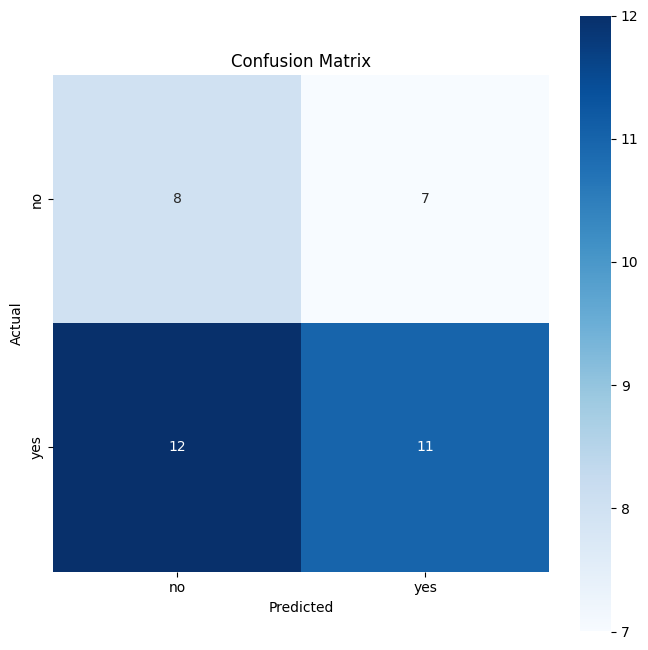

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(test_cm1, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_ds.class_indices.keys(), yticklabels=test_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

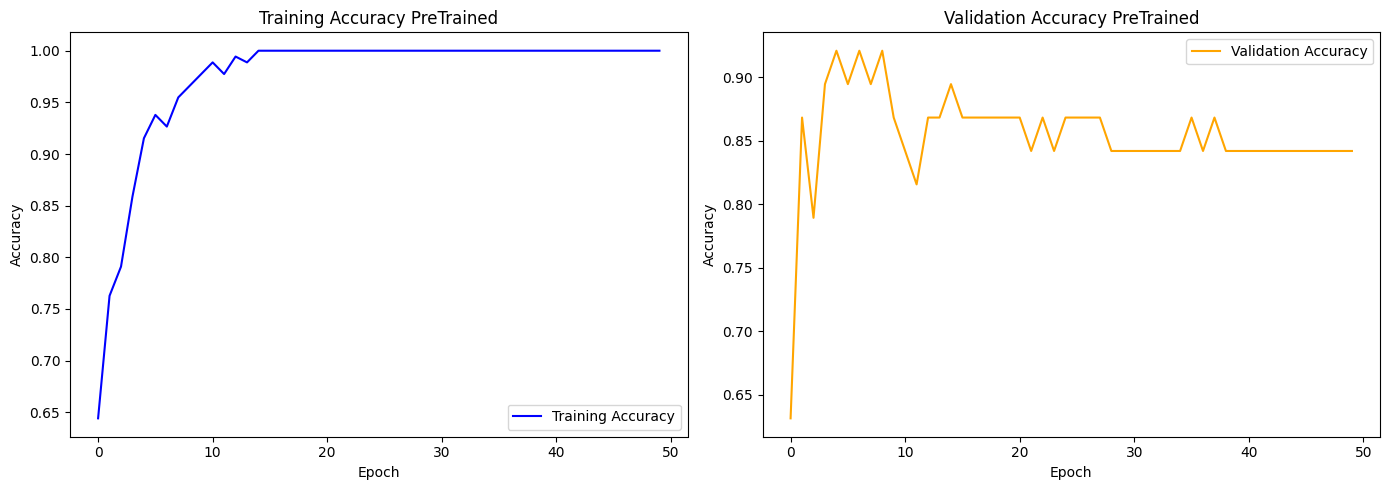

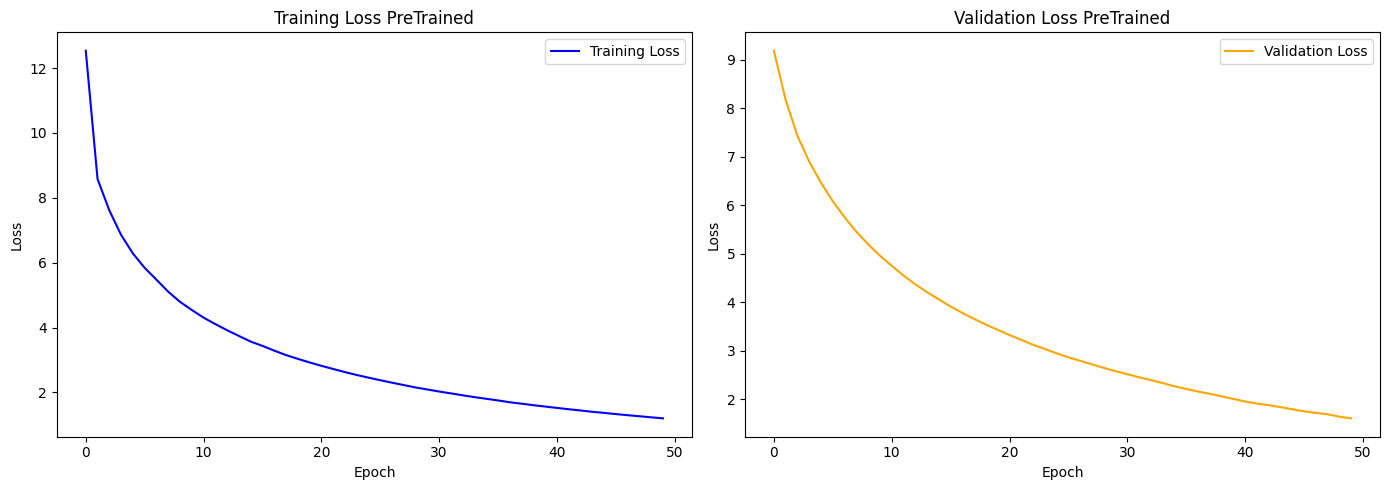

In [ ]:
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy PreTrained')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy PreTrained')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss PreTrained')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss PreTrained')
plt.legend()

plt.tight_layout()
plt.show()

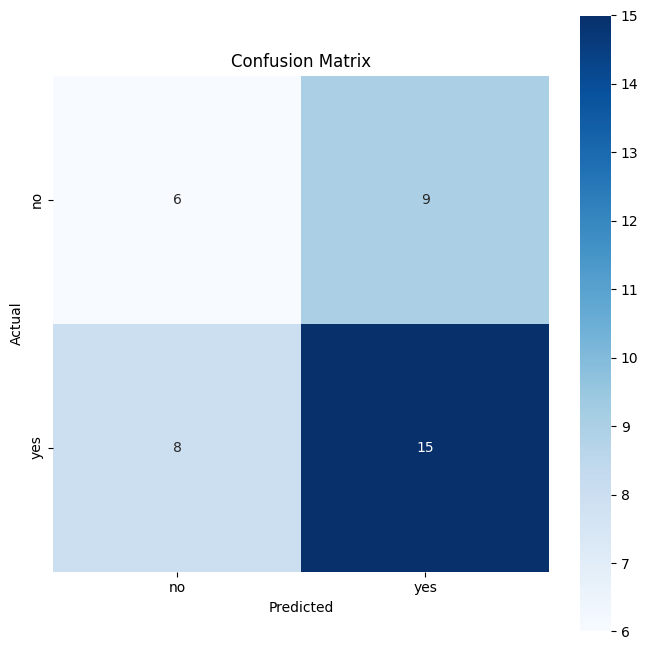

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(test_cm2, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_ds.class_indices.keys(), yticklabels=test_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Conclusion
Overall the both of the models plateau around a similar accuracy, however the ground up model demonstrates much higher F1 scores meaning it is likely more desirable for actual evaluation. However the classification does still fall short. This is likely due to the types of tumors not being defined. THis is a definite avenue of improvement to look to in the future.